In [83]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [63]:
RANDOM_STATE = 42
BENIGN_TARGET = 75_000
MALICIOUS_TARGET = 25_000

GLOBAL_FEATURE_REDUCTION_RATIO = 0.5
FINAL_FEATURES = 30

In [64]:
benign_df = pd.read_csv("output-of-benign-pcap-0.csv")
malware_df = pd.read_csv("output-of-malware-pcap.csv")
phishing_df = pd.read_csv("output-of-phishing-pcap.csv")
spam_df = pd.read_csv("output-of-spam-pcap.csv")

In [65]:
benign_df["label"] = 0
malware_df["label"] = 1
phishing_df["label"] = 1
spam_df["label"] = 1

malicious_df = pd.concat(
    [malware_df, phishing_df, spam_df],
    ignore_index=True
)

benign_df = benign_df.sample(BENIGN_TARGET, random_state=RANDOM_STATE)
malicious_df = malicious_df.sample(MALICIOUS_TARGET, random_state=RANDOM_STATE)

df = pd.concat([benign_df, malicious_df], ignore_index=True)
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print("Class distribution:")
print(df["label"].value_counts())

Class distribution:
label
0    75000
1    25000
Name: count, dtype: int64


In [66]:
df.drop(columns=[c for c in df.columns if "unnamed" in c.lower()], inplace=True, errors="ignore")

df.drop(
    columns=[
        "flow_id", "timestamp",
        "src_ip", "dst_ip",
        "src_port", "dst_port",
        "dns_domain_name",
        "uni_gram_domain_name",
        "bi_gram_domain_name",
        "tri_gram_domain_name",
        "character_distribution"
    ],
    errors="ignore",
    inplace=True
)

In [67]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)


In [68]:
X = df.drop(columns=["label"])
y = df["label"]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns

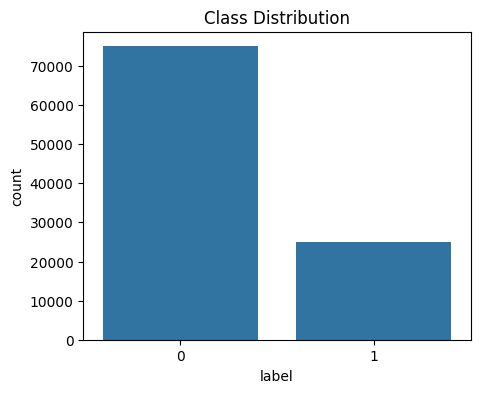

In [69]:
# 1. Class balance
plt.figure(figsize=(5, 4))
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()

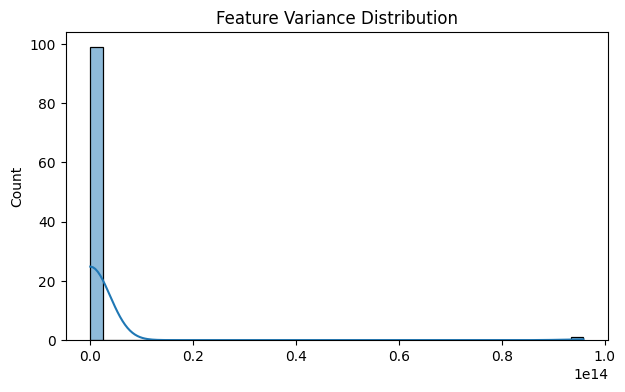

In [70]:
# 2. Feature variance distribution
variances = X[numeric_features].var().sort_values(ascending=False)
plt.figure(figsize=(7, 4))
sns.histplot(variances, bins=40, kde=True)
plt.title("Feature Variance Distribution")
plt.show()

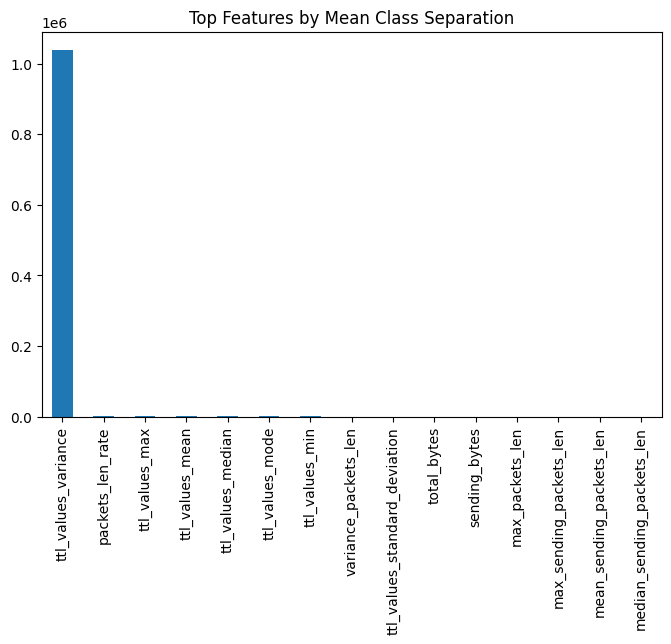

In [71]:
# 3. Mean class separation
mean_sep = (
    X[numeric_features][y == 1].mean() -
    X[numeric_features][y == 0].mean()
).abs().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
mean_sep.head(15).plot(kind="bar")
plt.title("Top Features by Mean Class Separation")
plt.show()

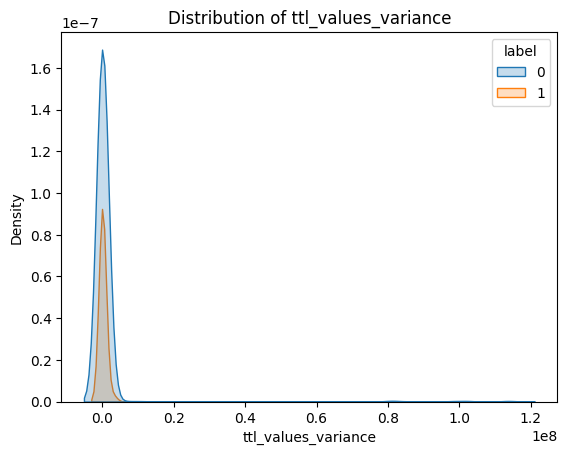

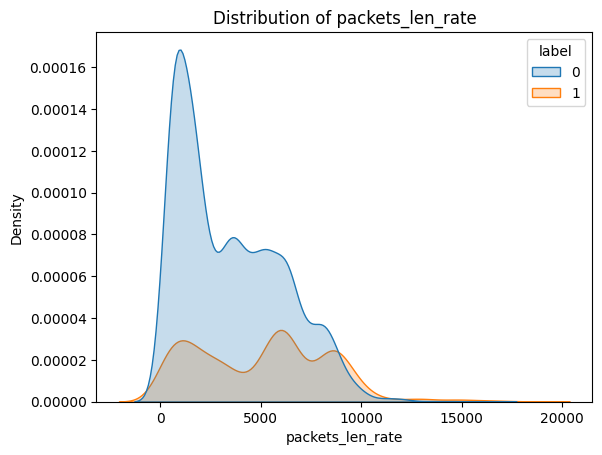

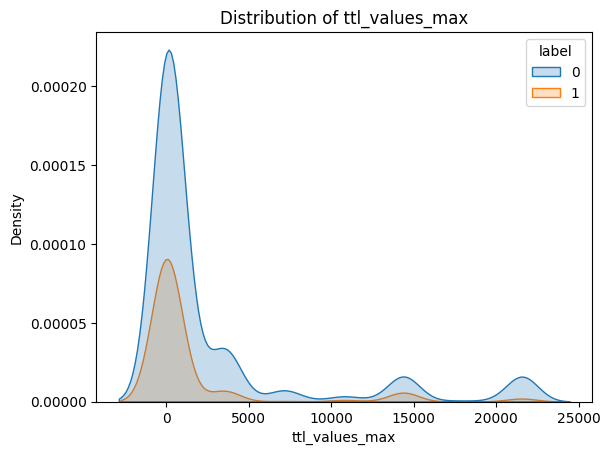

In [72]:
# 4. Distribution comparison
sample = df.sample(10_000, random_state=RANDOM_STATE)
for col in mean_sep.head(3).index:
    sns.kdeplot(sample, x=col, hue="label", fill=True)
    plt.title(f"Distribution of {col}")
    plt.show()

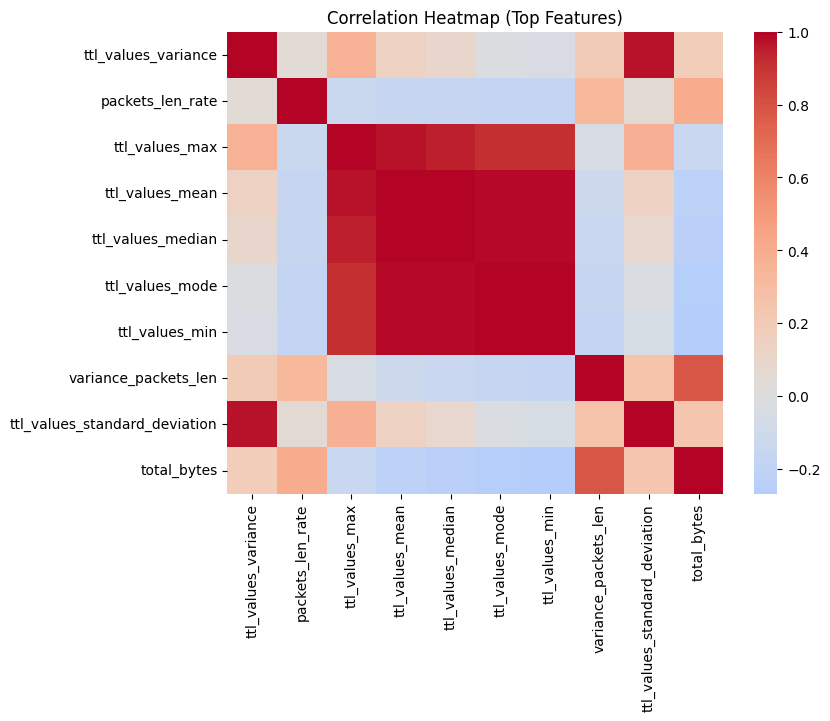

In [73]:
# 5. Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(X[mean_sep.head(10).index].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Top Features)")
plt.show()

In [74]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="drop"
)

In [75]:
X_pre = preprocessor.fit_transform(X)

vt = VarianceThreshold(threshold=0.0)
X_vt = vt.fit_transform(X_pre)
vt_features = numeric_features[vt.get_support()]

f_scores, _ = f_classif(X_vt, y)
f_scores = pd.Series(f_scores, index=vt_features).sort_values(ascending=False)

KEEP_N = int(len(f_scores) * GLOBAL_FEATURE_REDUCTION_RATIO)
selected_global_features = f_scores.head(KEEP_N).index.tolist()

print(f"Global feature reduction: {len(numeric_features)} → {KEEP_N}")

X_reduced = X[selected_global_features]

Global feature reduction: 100 → 39


In [76]:
models = {
    "LASSO Logistic Regression": (
        LogisticRegression(
        penalty="elasticnet",
        l1_ratio=1.0,          
        solver="saga",
        class_weight="balanced",
        max_iter=2000
        ),
        {"clf__C": [0.01, 0.1, 1, 10]}
    ),
    "SVM (RBF)": (
        SVC(kernel="rbf", class_weight="balanced"),
        {"clf__C": [1, 10], "clf__gamma": ["scale", 0.01]}
    ),
    "KNN (k=5)": (
        KNeighborsClassifier(n_neighbors=5),
        {}
    ),
    "KNN (k=7)": (
        KNeighborsClassifier(n_neighbors=7),
        {}
    ),
    "Random Forest": (
        RandomForestClassifier(
            n_estimators=200,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        {"clf__max_depth": [None, 20]}
    )
}

In [77]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []

for name, (clf, params) in models.items():
    print(f"Training {name}")

    pipeline = Pipeline([
        ("scale", StandardScaler()),
        ("vt", VarianceThreshold(0.0)),
        ("select", SelectKBest(f_classif, k=FINAL_FEATURES)),
        ("clf", clf)
    ])

    start = time.time()

    if params:
        grid = GridSearchCV(pipeline, params, scoring="f1", cv=cv, n_jobs=-1)
        grid.fit(X_reduced, y)
        best_model = grid.best_estimator_
    else:
        best_model = pipeline.fit(X_reduced, y)

    elapsed = time.time() - start

    scores = cross_validate(
        best_model, X_reduced, y,
        cv=cv,
        scoring=["accuracy", "precision", "recall", "f1"],
        n_jobs=-1
    )

    results.append({
        "Model": name,
        "Accuracy": scores["test_accuracy"].mean(),
        "Precision": scores["test_precision"].mean(),
        "Recall": scores["test_recall"].mean(),
        "F1": scores["test_f1"].mean(),
        "Training Time": elapsed
    })

results_df = pd.DataFrame(results)
print(results_df)

Training LASSO Logistic Regression


c:\Users\belal\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Training SVM (RBF)
Training KNN (k=5)
Training KNN (k=7)
Training Random Forest
                       Model  Accuracy  Precision   Recall        F1  \
0  LASSO Logistic Regression   0.72888   0.471765  0.70552  0.565430   
1                  SVM (RBF)   0.76656   0.524470  0.70996  0.603260   
2                  KNN (k=5)   0.83758   0.710189  0.59188  0.645635   
3                  KNN (k=7)   0.83904   0.720904  0.58120  0.643536   
4              Random Forest   0.85504   0.744695  0.63932  0.687985   

   Training Time  
0     186.359813  
1    4236.660760  
2       0.174214  
3       0.185584  
4      50.241027  


C:\Users\belal\AppData\Local\Temp\ipykernel_25256\3978079128.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


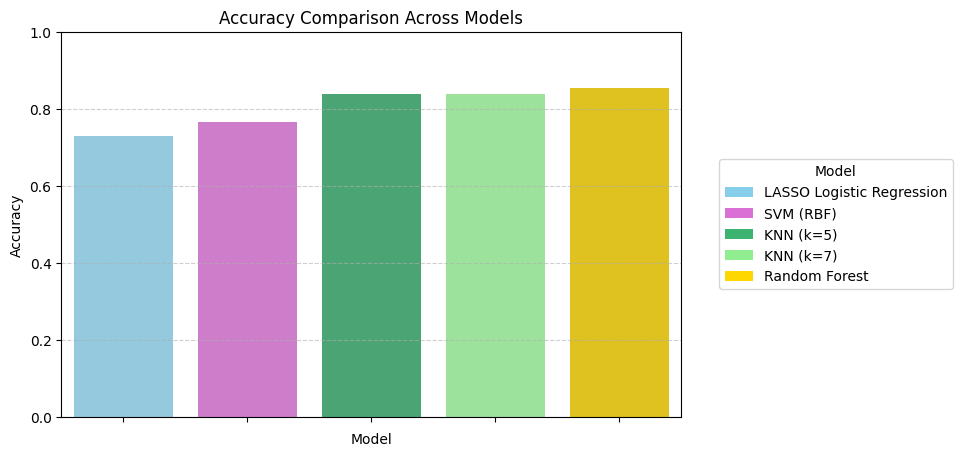

C:\Users\belal\AppData\Local\Temp\ipykernel_25256\3978079128.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


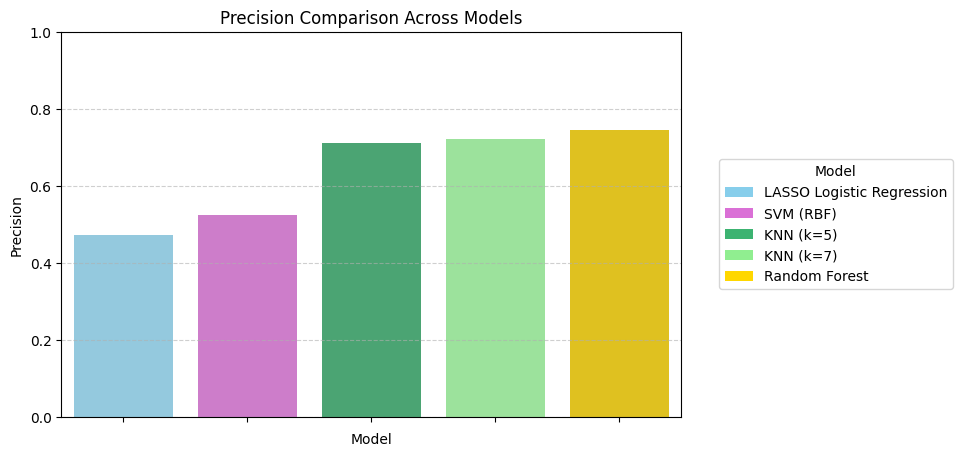

C:\Users\belal\AppData\Local\Temp\ipykernel_25256\3978079128.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


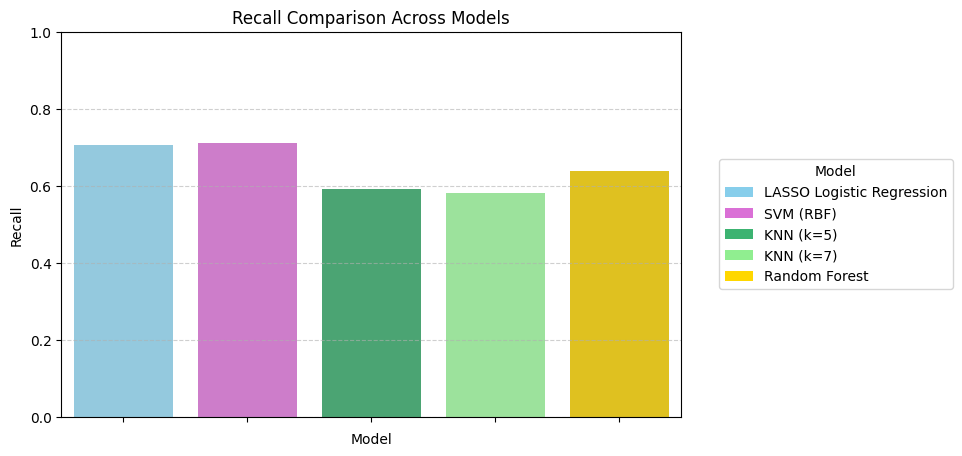

C:\Users\belal\AppData\Local\Temp\ipykernel_25256\3978079128.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


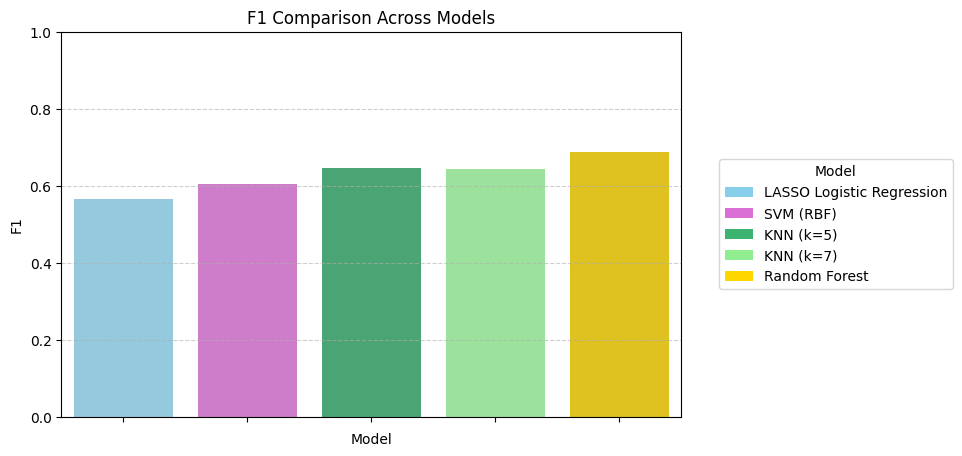

C:\Users\belal\AppData\Local\Temp\ipykernel_25256\3978079128.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


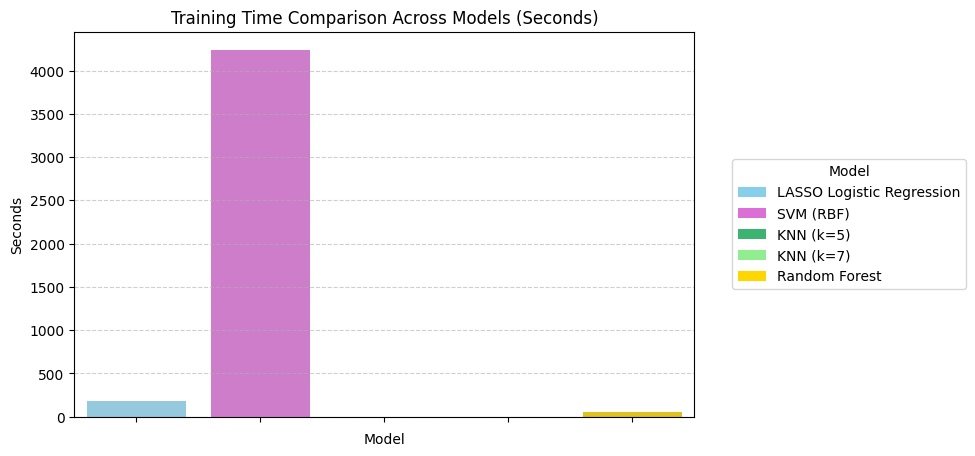

C:\Users\belal\AppData\Local\Temp\ipykernel_25256\3978079128.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


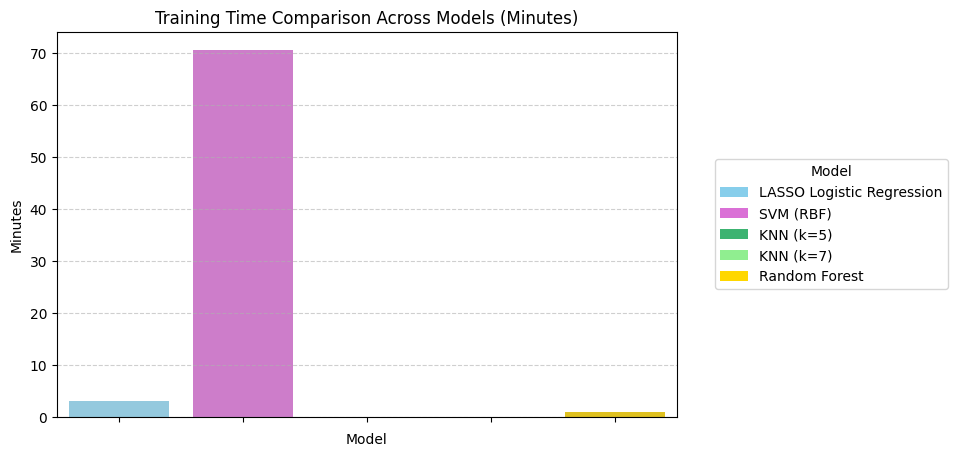

In [84]:
model_color_map = {
    "LASSO Logistic Regression": "skyblue",
    "SVM (RBF)": "orchid",
    "KNN (k=5)": "mediumseagreen",
    "KNN (k=7)": "lightgreen",
    "Random Forest": "gold"
}

metrics = ["Accuracy", "Precision", "Recall", "F1"]

for metric in metrics:
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=results_df,
        x="Model",
        y=metric,
        palette=model_color_map
    )
    
    plt.title(f"{metric} Comparison Across Models")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    
    # Hide x-axis labels
    ax.set_xticklabels([])
    
    # Manually create legend
    legend_elements = [Patch(facecolor=color, label=name) for name, color in model_color_map.items()]
    ax.legend(handles=legend_elements, title="Model", bbox_to_anchor=(1.05, 0.5), loc='center left')
    
    plt.show()

# Training Time in seconds
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=results_df,
    x="Model",
    y="Training Time",
    palette=model_color_map
)
plt.title("Training Time Comparison Across Models (Seconds)")
plt.ylabel("Seconds")
plt.grid(axis="y", linestyle="--", alpha=0.6)
ax.set_xticklabels([])
legend_elements = [Patch(facecolor=color, label=name) for name, color in model_color_map.items()]
ax.legend(handles=legend_elements, title="Model", bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.show()

# Training Time in minutes
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=results_df,
    x="Model",
    y=results_df["Training Time"] / 60,
    palette=model_color_map
)
plt.title("Training Time Comparison Across Models (Minutes)")
plt.ylabel("Minutes")
plt.grid(axis="y", linestyle="--", alpha=0.6)
ax.set_xticklabels([])
legend_elements = [Patch(facecolor=color, label=name) for name, color in model_color_map.items()]
ax.legend(handles=legend_elements, title="Model", bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.show()